# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Flatten, RepeatVector, Reshape, TimeDistributed, Lambda, Dense, Dropout
from scipy import stats 
from scipy.optimize import curve_fit 
from scipy.stats import norm, lognorm
import tensorflow as tf
from pathlib import Path

from load import load_links
from DQR.models import tilted_loss, convLSTM

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))
print("Tensorflow Version .{}".format(tf.__version__))
print("Numpy Version .{}".format(np.__version__))

Found GPU at: /device:GPU:0
Tensorflow Version .2.3.1
Numpy Version .1.16.2


# Data Preprocessing

In [2]:
def roll(ix, ts, lags, preds):
    X = np.stack([np.roll(ts, i, axis=0) for i in range(lags, 0, -1)], axis=1)[lags:-preds,]
    Y = np.stack([np.roll(ts, -i, axis=0) for i in range(0, preds, 1)], axis=1)[lags:-preds,]
    Y_ix = ix[lags:-preds]
    return X, Y, Y_ix

def load_data(line, freq, lags, preds):
    train = pd.read_csv(f'Data/{line}_{freq}_train_norm.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    train_counts = pd.read_csv(f'Data/{line}_{freq}_train_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_train, Y_train, Y_train_ix = roll(train.index, train.values, lags, preds)
    
    val = pd.read_csv(f'Data/{line}_{freq}_val_norm.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    val_counts = pd.read_csv(f'Data/{line}_{freq}_val_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_val, Y_val, Y_val_ix = roll(val.index, val.values, lags, preds)

    test = pd.read_csv(f'Data/{line}_{freq}_test_norm.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_counts = pd.read_csv(f'Data/{line}_{freq}_test_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_mean = pd.read_csv(f'Data/{line}_{freq}_test_mean.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_std = pd.read_csv(f'Data/{line}_{freq}_test_std.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_test, Y_test, Y_test_ix = roll(test.index, test.values, lags, preds)
    _, mu_test, _ = roll(test_mean.index, test_mean.values, lags, preds)
    _, sigma_test, _ = roll(test_std.index, test_std.values, lags, preds)
        
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test, Y_test_ix, mu_test, sigma_test)

In [3]:
line = '200S'
freq = '15min'
lags = 32
preds = 3


data_train, data_val, data_test = load_data(line, freq, lags, preds)

# Unpack tensors
(X_train, y_train) = data_train
(X_val, y_val) = data_val
(X_test, y_test, y_ix_test, y_mean_test, y_std_test) = data_test

X_train = X_train[..., np.newaxis, np.newaxis]
y_train = y_train[..., np.newaxis, np.newaxis]
X_val = X_val[..., np.newaxis, np.newaxis]
y_val = y_val[..., np.newaxis, np.newaxis]
X_test = X_test[..., np.newaxis, np.newaxis]
y_test = y_test[..., np.newaxis, np.newaxis]

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

X_train (8701, 32, 29, 1, 1) y_train (8701, 3, 29, 1, 1)
X_val (1309, 32, 29, 1, 1) y_val (1309, 3, 29, 1, 1)
X_test (1309, 32, 29, 1, 1) y_test (1309, 3, 29, 1, 1)


In [4]:
quantiles = np.sort([0.025, 0.975, 0.05, 0.95, 0.10, 0.90, 0.20, 0.8, 0.4, 0.6])
y_traink = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
y_valk  = np.zeros((y_val.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
for i in range(len(quantiles)+1):
    y_traink[:,:,:,:,i] = y_train[:,:,:,:,0]
    y_valk[:,:,:,:,i] = y_val[:,:,:,:,0]

In [5]:
quantiles

array([0.025, 0.05 , 0.1  , 0.2  , 0.4  , 0.6  , 0.8  , 0.9  , 0.95 ,
       0.975])

# Joint Model (Encoder-Decoder ConvLSTM)

In [6]:
def joint_convLstm(num_filters, kernel_length, input_timesteps, num_links, output_timesteps, quantiles, prob, loss, opt):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = num_filters, kernel_size = (kernel_length, 1), 
                         padding='same',
                         return_sequences=False))

    model.add(Dropout(prob, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_links, 1, num_filters)))

    model.add(ConvLSTM2D(name ='conv_lstm_2',filters = num_filters, kernel_size = (kernel_length, 1), padding='same',return_sequences = True))
    model.add(Dropout(prob, name = 'dropout_2'))

    model.add(TimeDistributed(Dense(units = len(quantiles) + 1, name = 'dense_1')))
    model.compile(loss = loss, optimizer = opt)
    return model

# Training

In [7]:
# Tilted loss for both mean and quantiles
def joint_tilted_loss(quantiles, y, f):
    loss = K.mean(K.square(y[:,:,:,0,0]-f[:,:,:,0,0]), axis = -1)
    for k in range(len(quantiles)):
        q = quantiles[k]
        e = (y[:,:,:,0,k+1]-f[:,:,:,0,k+1])
        loss += K.mean(K.maximum(q*e, (q-1)*e))
    return loss


In [8]:
# Best parameters [79, 1, 0.10521284879519917]
# Validation Loss 2.3823776245117188

num_filters = 79
kernel_length = 1
prob = 0.10521284879519917
num_links = X_train.shape[2]
lags = X_train.shape[1]
opt = tf.keras.optimizers.Adagrad(learning_rate=1e-3) #1e-3
loss = lambda y, f: joint_tilted_loss(quantiles, y, f)
net = joint_convLstm(num_filters, kernel_length, lags, num_links, preds, quantiles, prob, loss, opt)
mc = tf.keras.callbacks.ModelCheckpoint( filepath="Model Checkpoint/joint",
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
net.fit(X_train, y_traink, validation_data=(X_val, y_valk), batch_size=50, callbacks=[es, mc], epochs=200)
net.load_weights("Model Checkpoint/joint")
y_pred = net.predict(X_test)
## Sort only the quantiles
y_pred[:,:,:,:,1:] = np.sort(y_pred[:,:,:,:,1:], axis=4)

Epoch 1/200
175/175 [==============================] - 29s 166ms/step - loss: 3.8147 - val_loss: 4.1298
Epoch 2/200
175/175 [==============================] - 29s 164ms/step - loss: 3.5397 - val_loss: 3.9641
Epoch 3/200
175/175 [==============================] - 28s 162ms/step - loss: 3.3562 - val_loss: 3.6331
Epoch 4/200
175/175 [==============================] - 29s 165ms/step - loss: 3.2106 - val_loss: 3.3449
Epoch 5/200
175/175 [==============================] - 29s 166ms/step - loss: 3.1003 - val_loss: 3.2039
Epoch 6/200
175/175 [==============================] - 29s 167ms/step - loss: 3.0147 - val_loss: 3.1208
Epoch 7/200
175/175 [==============================] - 29s 167ms/step - loss: 2.9491 - val_loss: 3.0608
Epoch 8/200
175/175 [==============================] - 29s 164ms/step - loss: 2.8970 - val_loss: 3.0144
Epoch 9/200
175/175 [==============================] - 29s 163ms/step - loss: 2.8564 - val_loss: 2.9771
Epoch 10/200
175/175 [==============================] - 29s 165m

In [10]:
np.save('DQR/y_test_pred_joint_200s.npy', y_pred)
np.save('DQR/y_test_200s.npy', y_test)
np.save('DQR/y_test_mean_200s.npy', y_mean_test)
np.save('DQR/y_test_std_200s.npy', y_std_test)

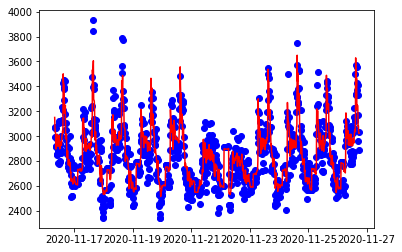

In [11]:
up_to = 1000
plt.plot(y_ix_test[:up_to], np.sum(y_test[:up_to,0,:,0,0]*y_std_test[:up_to,0,:]+y_mean_test[:up_to,0,:], axis=1), 'bo')
plt.plot(y_ix_test[:up_to], np.sum(y_pred[:up_to,0,:,0,0]*y_std_test[:up_to,0,:]+y_mean_test[:up_to,0,:], axis=1), 'r')

# Quantile Sampling (Example)

-0.3215702389568721 0.909438556843736


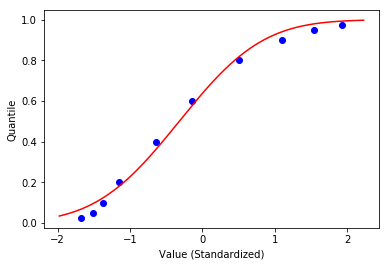

In [12]:
S=500
t = 60
ln = 12
(mu, sigma), _ = curve_fit(lambda x, mu, sigma: norm.cdf(x, mu, sigma), y_pred[t,0,ln,0,1:].astype(float), quantiles)
print(mu, sigma)
x = np.linspace(y_pred[t,0,ln,0,1] - 0.3, y_pred[t,0,ln,0,-1] + 0.3, 1000)
plt.plot(y_pred[t,0,ln,0,1:], quantiles, 'bo')
plt.xlabel('Value (Standardized)')
plt.ylabel('Quantile')
plt.plot(x, norm.cdf(x, mu, sigma), 'r')

(array([  4.,   7.,  30.,  75.,  80., 107., 113.,  53.,  26.,   5.]),
 array([-3.22647092, -2.6865004 , -2.14652987, -1.60655935, -1.06658883,
        -0.52661831,  0.01335221,  0.55332274,  1.09329326,  1.63326378,
         2.1732343 ]),
 <a list of 10 Patch objects>)

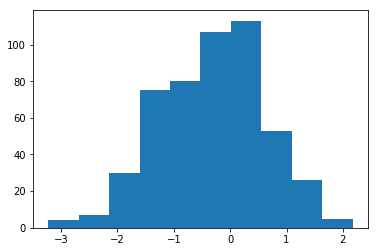

In [13]:
plt.hist(norm.rvs(loc=mu, scale=sigma, size=S))